### V1DD Figure 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import transforms
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient


In [2]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
# color = ['red', 'blue', 'orange', 'green']
# color = ['#88CCEE', "#44AA99", "#117733", "#999933"] 
# color = ['#88CCEE', "#117733", "#DDCC77", "#CC6677"]
# color = ['#0077BB', "#009988", "#EE7733", "#EE3377"]
color = ["#66CCEE", "#228833", "#CCBB44", "#EE6677"]
all_z = [50, 66, 82, 98, 114, 130, 146, 162, 178, 194, 210, 226, 242, 258, 274, 290, 306, 322, 338, 354, 370, \
    386, 402, 418, 434, 450, 466, 482, 498, 514, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725]

# plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

#### Load and preprocess the data

In [3]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [4]:
print(f"There are {len(cell_info)} total neurons.")

There are 88351 total neurons.


#### Plot the number of ROIs vs depth

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


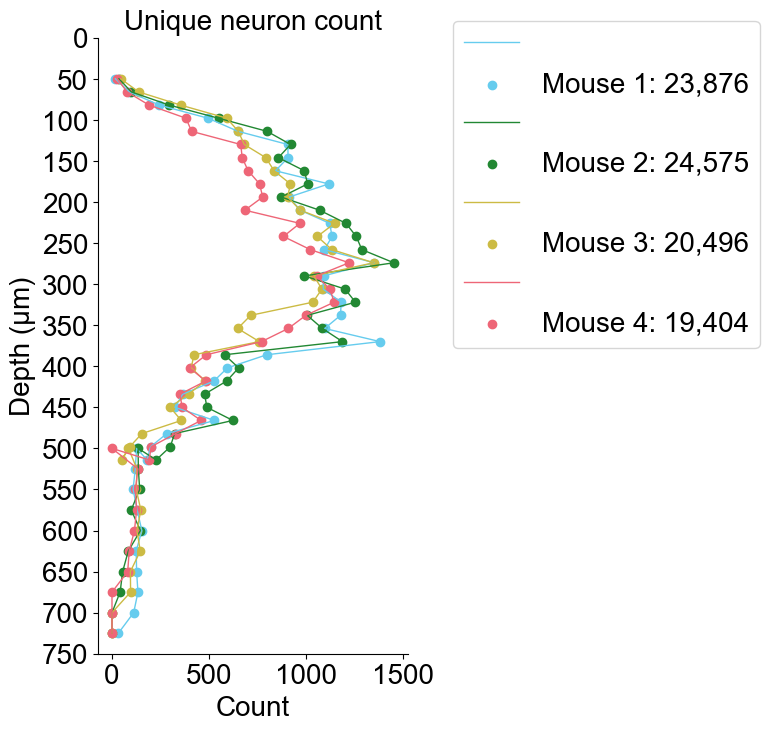

In [5]:
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot(111)
data = np.zeros([len(all_z), 4])
for i, z in enumerate(all_z):
    for k in range(len(mice)):
        plane = (cell_info['z']==z) & (cell_info['mouse_id']==mice[k])
        data[i, k] = cell_info[plane].shape[0]
        
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

for i in range(4):
    
    ax.plot(data[:, i], all_z,
            linewidth=1, color = color[i])
    plt.scatter(all_z, 
                -data[:, i], 
                color = color[i], 
                label = mice[i],
                transform = rot + base)

plt.legend(["", "Mouse 1: 23,876", "", "Mouse 2: 24,575", "", "Mouse 3: 20,496","",  "Mouse 4: 19,404"], bbox_to_anchor=(1.1, 1.05), fontsize=20)
plt.ylim(0, 750)
plt.yticks(np.arange(0, 800, 50), fontsize=20)
plt.xticks(np.arange(0, 1501, 500), fontsize=20)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Unique neuron count', fontsize=20)
plt.xlabel('Count', fontsize=20)
plt.ylabel('Depth (µm)', fontsize=20)

plt.savefig('/home/naomi/Desktop/figures/v1dd_plots/1E_population_depth_boxplot.eps', dpi=300, bbox_inches='tight')

### Plot example session order

In [6]:
mouse_id = 'M427836'
col_vol_str = '51'
plane = 2
plane_name = f"Plane_{plane}"

# DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session('M427836_11')

dff_traces = session.get_traces(trace_type='dff', plane=3)

Stimulus: drifting_gratings_full, Color: #0173b2
Stimulus: drifting_gratings_windowed, Color: #de8f05
Stimulus: locally_sparse_noise, Color: #029e73
Stimulus: natural_images, Color: #d55e00
Stimulus: natural_images_12, Color: #cc78bc
Stimulus: natural_movie, Color: #ca9161
Stimulus: spontaneous, Color: #949494


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/matplotlib/transforms.py:2035: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


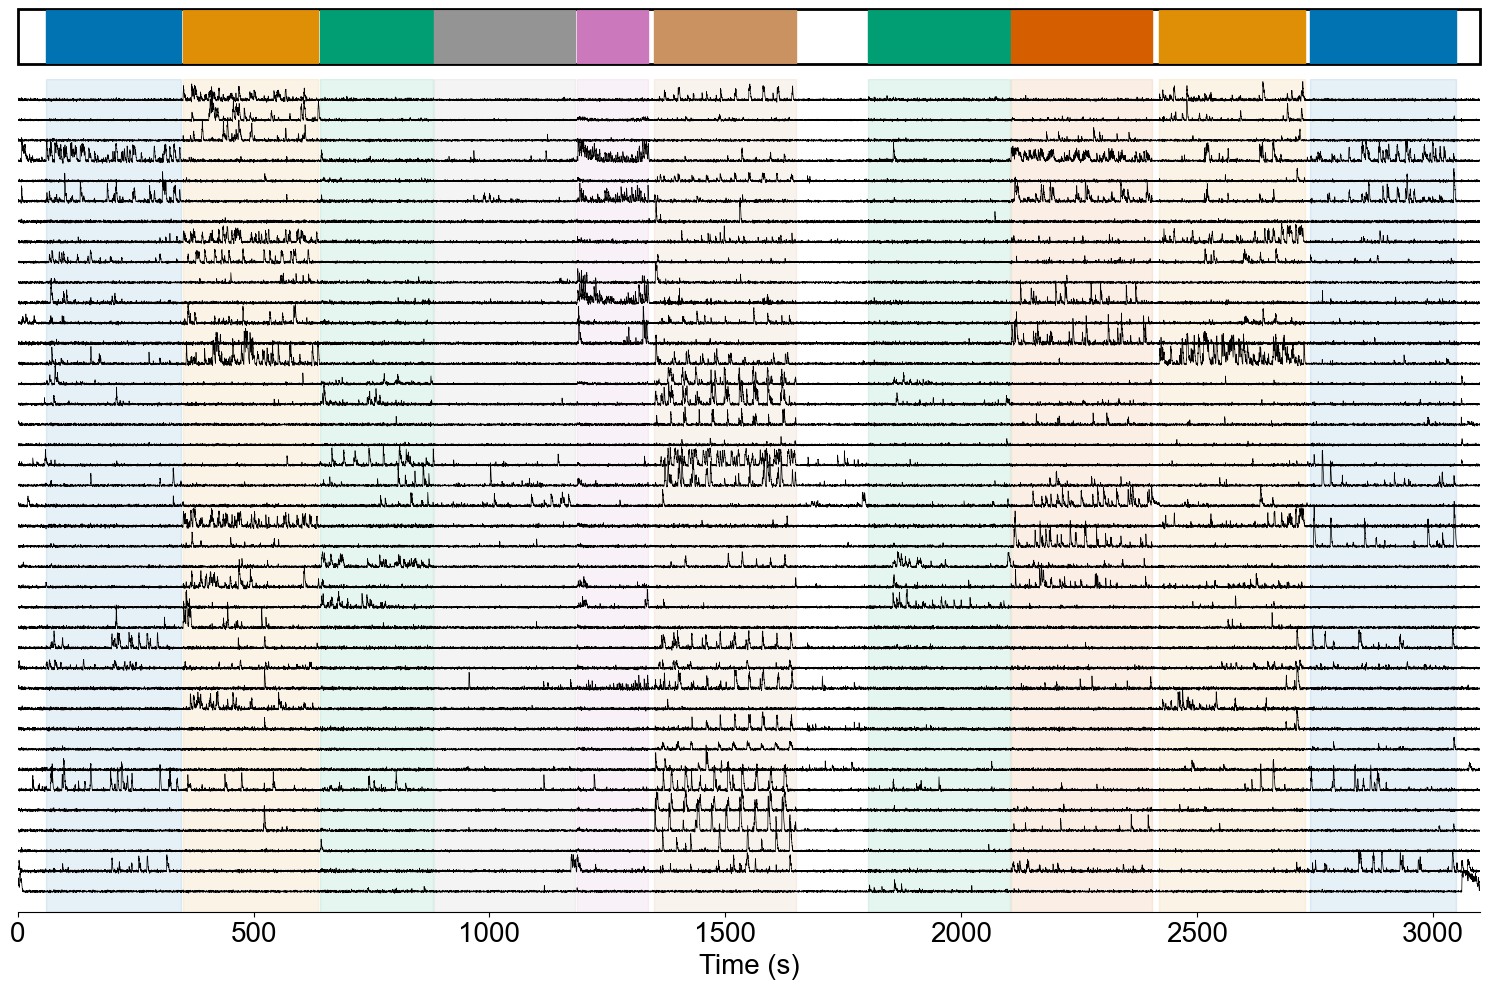

In [7]:
stims = [
    'drifting_gratings_full',
    'drifting_gratings_windowed',
    'locally_sparse_noise',
    'natural_images',
    'natural_images_12',
    'natural_movie',
    'spontaneous'
]
colors = sns.color_palette("colorblind", len(stims) + 1).as_hex()
stims_colors = {stim: color for stim, color in zip(stims, colors)}
stims_colors['spontaneous'] = colors[-1]  # Use the last color for spontaneous (grey)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 15]})

# Plotting the stimulus blocks
for stim, color in stims_colors.items():
    print(f'Stimulus: {stim}, Color: {color}')
    stim_table = session.get_stimulus_table(stim_name=stim)[0]

    starts = stim_table.start.values
    ends = stim_table.end.values

    start_end_pairs = []
    min_start = starts.min()
    max_end = ends.min()
    for i, (start, end) in enumerate(zip(starts, ends)):
        # Check if the current end is more than 10 s after the previous start (end of the stimulus block)
        try: 
            if end > 10 + starts[i-1]:
                start_end_pairs.append((min_start, max_end))
                min_start = np.inf
                max_end = -np.inf
        except IndexError:
            pass

        # Check if at the end of the list to add the last pair
        try:
            ends[i+1]
        except IndexError:
            start_end_pairs.append((min_start, max_end))


        if start < min_start:
            min_start = start
        if end > max_end:
            max_end = end
            
    for start, end in start_end_pairs:
        axs[0].axvspan(start, end, color=color, alpha=1, label=stim)
        axs[1].axvspan(start, end, color=color, alpha=0.1, label=stim)

axs[0].set_yticks([])
axs[0].set_ylim(0, 0.1)
axs[0].set_xlim(left=0, right=3100)
axs[0].set_xticks([])
axs[0].patch.set_linewidth(2)
axs[0].patch.set_edgecolor('black')


# Plotting the dff traces
offset = 3.5  # vertical space between traces
time = dff_traces.time.values 
for i, trace in enumerate(dff_traces.values[:40]):  # limit to first 40 traces for clarity
    axs[1].plot(time, trace + i * offset, color='black', linewidth=0.5)

axs[1].set_xlabel('Time (s)', fontsize=20)
axs[1].set_ylim(-offset, 40 * offset)
axs[1].set_xlim(left=0, right=3100)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].yaxis.set_visible(False)
axs[1].spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()
plt.savefig('/home/naomi/Desktop/figures/v1dd_plots/1B_example_session.svg', dpi=300, bbox_inches='tight')